In [ ]:
!git clone https://github.com/cambridgeltl/visual-spatial-reasoning.git
%cd visual-spatial-reasoning

!pip install huggingface_hub
!huggingface-cli login
!pip install datasets==2.9.0

fatal: destination path 'visual-spatial-reasoning' already exists and is not an empty directory.
/content/visual-spatial-reasoning


5621


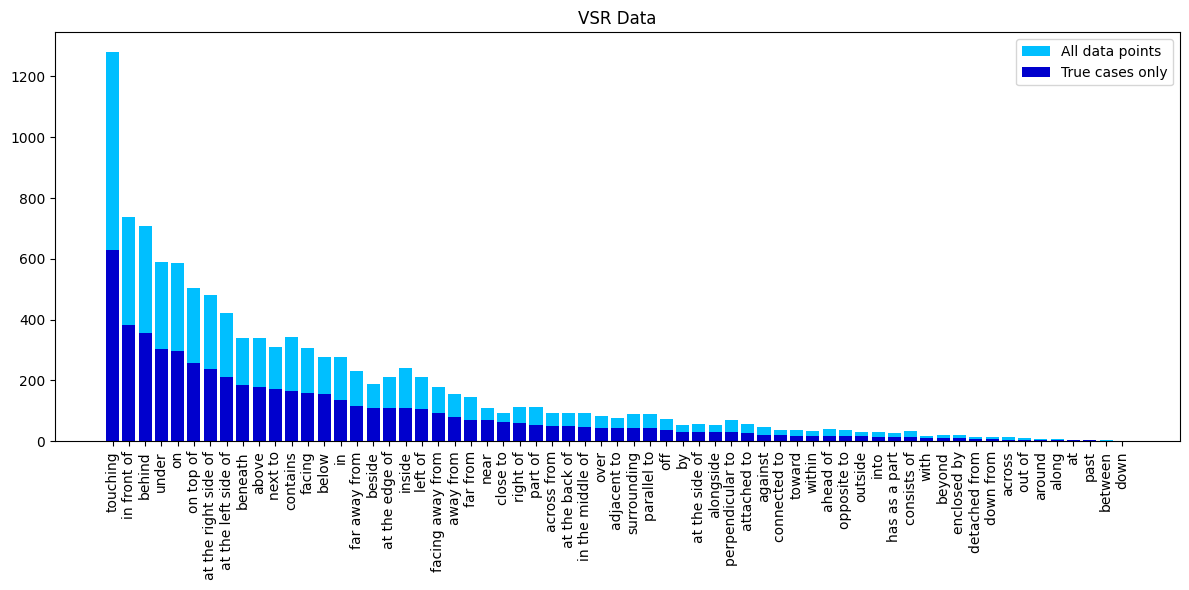

4920


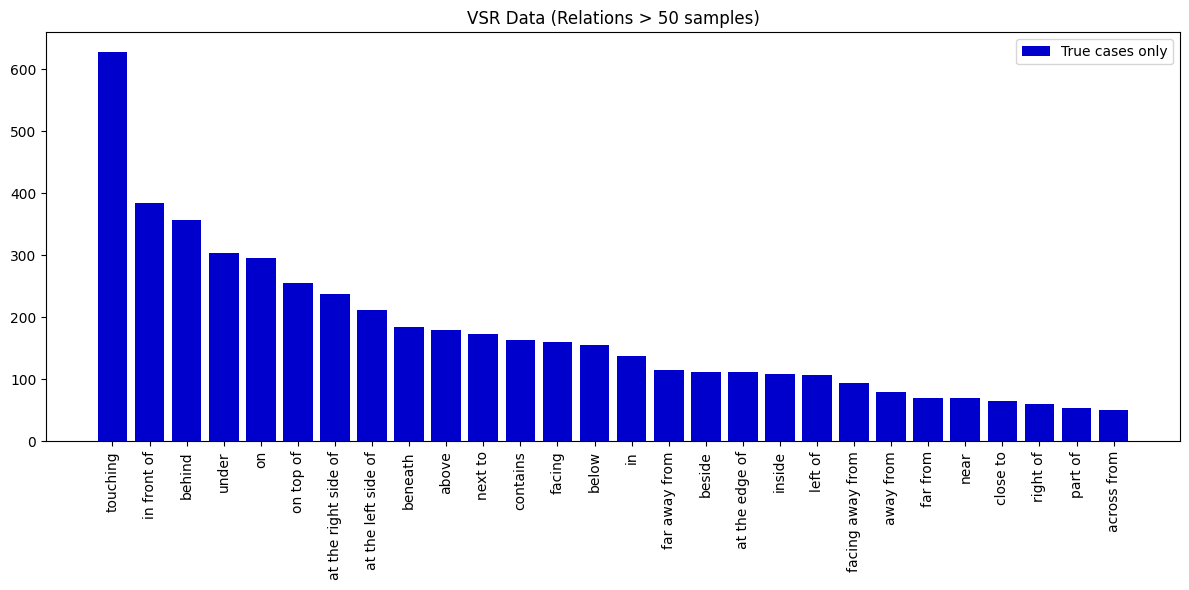

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

filepath = 'all_vsr_validated_data.jsonl'
data = pd.read_json(path_or_buf=filepath, lines=True)

true_data = data[data['label'] == 1][['image', 'image_link', 'caption', 'relation']]
true_data.columns = ['file_name', 'image_link', 'caption', 'relation']
print(len(true_data)) # 5621

x = data['relation'].value_counts()
y = true_data['relation'].value_counts()
a = "deepskyblue"
c = "mediumblue"

hist = plt.figure(figsize=(12, 6))
plt.bar(y.index, x[y.index], align='center', color=a)
plt.bar(y.index, y, align='center', color=c)
plt.xticks(rotation=90)
plt.title("VSR Data")
plt.legend(['All data points', 'True cases only'])
plt.tight_layout()
plt.savefig('vsr_all_his.png')
plt.show()

y = y[y > 50]
print(sum(y))  # 4920

hist = plt.figure(figsize=(12, 6))
plt.bar(y.index, y, align='center', color=c)
plt.xticks(rotation=90)
plt.title("VSR Data (Relations > 50 samples)")
plt.legend(['True cases only'])
plt.tight_layout()
plt.savefig('vsr_50_hist.png')
plt.show()

In [ ]:
# true_data.apply(download_image, axis=1)
# print(len(true_data))
# print(true_data['file_name'].nunique())
# print (len([name for name in os.listdir('img_data')]))

dupes = true_data[true_data['file_name'].duplicated()]
uniques = true_data.drop_duplicates(['file_name'])

print(len(dupes))
print(len(uniques))

# delete dupes
for i in dupes['file_name']:
  try:
    os.remove(path + i)
    print (len([name for name in os.listdir('img_data')]))
  except:
    pass #print("already deleted")

dupes['file_name'] = dupes.apply(lambda x: str(x.name) + x['file_name'], axis=1)
# print(dupes.sort_values(by='image_link'))
print(len(dupes))

deduped = pd.concat([uniques, dupes])
print(len(deduped))

1634
3987
1634
5621


<ipython-input-98-442ded535b25>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dupes['file_name'] = dupes.apply(lambda x: str(x.name) + x['file_name'], axis=1)


In [ ]:
import concurrent.futures
import os, os.path
import urllib.request
from PIL import Image

# download image files
def download_image(i):
  if i[1]['file_name'] not in os.listdir('img_data'):
    urllib.request.urlretrieve(i[1]['image_link'], path + i[1]['file_name'])
    print (len([name for name in os.listdir('img_data')]))

with concurrent.futures.ThreadPoolExecutor() as executor:
    for row in deduped.iterrows():
      executor.map(download_image(row))

In [ ]:
from functools import lru_cache
mirror_relations = ['left of', 'right of', 'at the left side of', 'at the right side of']
mirror_swaps = {'left of': 'right of', 'right of': 'left of', 'at the left side of': 'at the right side of', 'at the right side of': 'at the left side of'}


lr_data = deduped[deduped['relation'].isin(mirror_relations)]
rl_data = lr_data.copy()

rl_data['relation'] = lr_data['relation'].replace(mirror_swaps)
rl_data['file_name'] = rl_data.apply(lambda x: 'rl' + x['file_name'], axis=1)
rl_data['caption'] = rl_data['caption'].replace(mirror_swaps, regex=True)

print(lr_data.head(5))
print(rl_data.head(5))

            file_name  \
2    000000266622.jpg   
66   000000135866.jpg   
81   000000440455.jpg   
87   000000110488.jpg   
124  000000393375.jpg   

                                                   image_link  \
2    http://images.cocodataset.org/train2017/000000266622.jpg   
66   http://images.cocodataset.org/train2017/000000135866.jpg   
81   http://images.cocodataset.org/train2017/000000440455.jpg   
87   http://images.cocodataset.org/train2017/000000110488.jpg   
124  http://images.cocodataset.org/train2017/000000393375.jpg   

                                         caption             relation  
2    The bowl is at the left side of the banana.  at the left side of  
66         The bed is right of the potted plant.             right of  
81     The tv is at the left side of the person.  at the left side of  
87   The oven is at the left side of the person.  at the left side of  
124  The laptop is at the left side of the cake.  at the left side of  
              file_name  \

In [ ]:
def flip_image(i):
  if i[1]['file_name'] not in os.listdir('img_data'):
    img = Image.open(path + i[1]['file_name'][2:])
    img = img.transpose(Image.FLIP_LEFT_RIGHT)
    img.save(path + i[1]['file_name'])
    print (len([name for name in os.listdir('img_data')]))


with concurrent.futures.ThreadPoolExecutor() as executor:
    for row in rl_data.iterrows():
      executor.map(flip_image(row))

augmented = pd.concat([deduped, rl_data])
print(len(augmented))

6237


In [ ]:
from datasets import load_dataset

# save metadata
path = "img_data/"
augmented[['file_name', 'caption', 'relation']].to_json(path + 'metadata.jsonl', lines=True, orient='records')

# convert to dataset and push
dataset = load_dataset("img_data", data_dir="./", split="train")
print(dataset)
dataset.push_to_hub("ktennyson6/augmented-vsr")

ModuleNotFoundError: ignored